In [1]:
import os
import json
import open_clip

import numpy as np

import cupy as cp
from cuml import TSNE
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import dlpack
from torchvision import transforms
from torch.utils.data import DataLoader, dataset

import matplotlib.pyplot as plt

from models import cond_stage_model2

from datalibs import EEGPrepDataset
from datalibs.compose import *

/home/user/anaconda3/envs/SD3/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
class Test_TopK_Retrival():
    def __init__(self, json_path:str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Load Config and Read Json file
        self.json_parser(json_path)
        
        # Make Dataset for test
        self.make_dataset(self.eeg_test_path, 
                          self.eeg_val_path, 
                          self.img_path,
                          224)

        # Set models
        self.define_models()

        # Set Loggers        
        self.metric_names    = ['top1_img_acc', 
                              'top1_label_acc', 
                              'top3_img_acc', 
                              'top3_label_acc', 
                              'top5_img_acc', 
                              'top5_label_acc', 
                              'top1_name_acc', 
                              'top3_name_acc', 
                              'top5_name_acc']
        # Set Metrics
        self.sim  = nn.CosineSimilarity()

    def top_k_acc(self, cos_sim_matrix, k=1, return_idx=False):
        batch_size         = len(cos_sim_matrix)
        topk_sim, topk_idx = cos_sim_matrix.topk(k=k, dim=1)
        try:
            topk_matrix        = (self.topk_labels == topk_idx).any(dim=1)
        except:
            print(self.topk_labels.shape)
            print(self.topk_idx.shape)
        topk_acc           = topk_matrix.sum().item() / batch_size
        if return_idx:
            return topk_acc, topk_idx
        else:
            return topk_acc
            
    def top_k_names(self, topk_idx):
        batch_size = topk_idx.shape[0]
        topk_names_acc = np.any(self.names == self.names[topk_idx.detach().cpu().numpy()].squeeze(-1), axis=1).sum() / batch_size
        return topk_names_acc
        

    def top_k_label(self, topk_idx):
        batch_size = topk_idx.shape[0]
        topk_label_acc = (self.label == self.label[topk_idx].squeeze(-1)).any(dim=1).sum() / batch_size
        return topk_label_acc
        

        
    @torch.no_grad()
    def __call__(self, mode = "valid"):
        image_embed_lst = []
        eeg_latent_lst  = []
        eeg_label_lst   = []
        eeg_name_lst    = []
        self.local_metric    = [0.0 for _ in self.metric_names]
        self.global_metric   = [0.0 for _ in self.metric_names]

        
        data_loader = self.loader_valid if mode == "valid" else self.loader_test

        progress_bar = tqdm(
                range(0, len(data_loader)),
                initial=0,
                desc=f'{mode} Embeddings',
            )
        
        for step, data in enumerate(data_loader):            
            eeg, image, label, ori_img, names = data['eeg'], data['image'], data['label'], data["ori_img"], data["name"]
            eeg = eeg.to(self.device)
            image = image.to(self.device)
            self.label = label.to(self.device).unsqueeze(1)
            
            # Ground Truth
            self.topk_labels = torch.arange(0, eeg.shape[0], device=self.device, dtype=torch.long).unsqueeze(1)

            # Get Data's Embeddings
            img_embed  = self.clip.encode_image(image)
            eeg_latent = self.model(eeg).mean(1)            
            
            # For Local Top-K retrival
            eeg_norm = F.normalize(eeg_latent, dim=1)  # [batch, 1024]
            img_norm = F.normalize(img_embed, dim=1)  # [batch, 1024]
            cos_sim_matrix = torch.matmul(eeg_norm, img_norm.T)

            # Top-1
            topk_acc, topk_idx = self.top_k_acc(cos_sim_matrix, k=1, return_idx=True)
            topk_label_acc = self.top_k_label(topk_idx)
            self.local_metric[0] += topk_acc
            self.local_metric[1] += topk_label_acc.detach().cpu().item()

            # Top-3
            topk_acc, topk_idx = self.top_k_acc(cos_sim_matrix, k=3, return_idx=True)
            topk_label_acc = self.top_k_label(topk_idx)
            self.local_metric[2] += topk_acc
            self.local_metric[3] += topk_label_acc.detach().cpu().item()

            # Top-5
            topk_acc, topk_idx = self.top_k_acc(cos_sim_matrix, k=5, return_idx=True)
            topk_label_acc = self.top_k_label(topk_idx)
            self.local_metric[4] += topk_acc
            self.local_metric[5] += topk_label_acc.detach().cpu().item()

            
            image_embed_lst.append(eeg_norm.detach().cpu())
            eeg_latent_lst.append(img_norm.detach().cpu())
            eeg_label_lst.append(label)
            eeg_name_lst += names # Because List
            progress_bar.update(1)
        
        ########################################
        #        Logging Local metrics
        ########################################
        print(f"{'='*24}")
        print("Local Metric Result")
        print(f"{'='*24}")
        for n, l in zip(self.metric_names, self.local_metric):
            print(n, ":", l/(step+1), end=" ")
        
        print()
        ########################################
        #            Global Round
        ########################################
        self.image_embed_lst = torch.concat(image_embed_lst, 0).to(self.device)
        self.eeg_latent_lst  = torch.concat(eeg_latent_lst, 0).to(self.device)
        self.label           = torch.concat(eeg_label_lst, 0).to(self.device).unsqueeze(1)
        self.names           = np.array(eeg_name_lst)[:, np.newaxis]
        self.topk_labels     = torch.arange(0, self.image_embed_lst.shape[0], device=self.device, dtype=torch.long).unsqueeze(1)

        cos_sim_matrix   = self.eeg_latent_lst @ self.image_embed_lst.T
        topk_acc, topk_idx = self.top_k_acc(cos_sim_matrix, k=1, return_idx=True)
        topk_label_acc     = self.top_k_label(topk_idx)
        topk_names_acc     = self.top_k_names(topk_idx)
        self.global_metric[0] += topk_acc
        self.global_metric[1] += topk_label_acc.detach().cpu().item()  
        self.global_metric[6] += topk_names_acc.item()

        # Top-3
        topk_acc, topk_idx = self.top_k_acc(cos_sim_matrix, k=3, return_idx=True)
        topk_label_acc     = self.top_k_label(topk_idx)
        topk_names_acc     = self.top_k_names(topk_idx)
        self.global_metric[2] += topk_acc
        self.global_metric[3] += topk_label_acc.detach().cpu().item()
        self.global_metric[7] += topk_names_acc.item()

        # Top-5
        topk_acc, topk_idx = self.top_k_acc(cos_sim_matrix, k=5, return_idx=True)
        topk_label_acc     = self.top_k_label(topk_idx)
        topk_names_acc     = self.top_k_names(topk_idx)
        self.global_metric[4] += topk_acc
        self.global_metric[5] += topk_label_acc.detach().cpu().item()
        self.global_metric[8] += topk_names_acc.item()
        
        ########################################
        #        Logging Global metrics
        ########################################
        print(f"{'='*24}")
        print("Global Metric Result")
        print(f"{'='*24}")
        for n, l in zip(self.metric_names, self.global_metric):
            print(n, ":", l, end=" ")
        print()
        
    def define_models(self):
        self.model = cond_stage_model2( pre_path = self.eeg_pretrian_path,
                                        in_seq = self.in_seq, 
                                        in_channels = self.in_channels, 
                                        out_channels = self.z_channels,
                                        out_seq = self.out_seq,
                                        dims = self.dims, 
                                        shortcut = self.shortcut, 
                                        dropout = self.dropout, 
                                        groups = self.groups,
                                        layer_mode = self.layer_mode,  
                                        block_mode = self.block_mode, 
                                        down_mode = self.down_mode,
                                        pos_mode = self.pos_mode, 
                                        n_layer =self.n_layer, 
                                        n_head = self.n_head,
                                        dff_factor= self.dff_factor,
                                        stride = self.stride, 
                                        skip_mode= self.skip_mode,
                                        global_attn = True).to(self.device)
        self.clip, self.train_transform, self.eval_transform = open_clip.create_model_and_transforms(self.model_id, 
                                                                                                     pretrained=self.pretrained, 
                                                                                                     force_custom_text=True)
        
        self.clip.eval()
        self.model.eval()
        
        for p in self.clip.parameters():
            p.requires_grad = False
            
        for p in self.model.parameters():
            p.requires_grad = False

        self.clip  = self.clip.to(self.device)
        self.model = self.model.to(self.device)
        
    def make_dataset(self, eeg_test_path, eeg_val_path, img_path, img_size, mean=None, std=None, min_value=0, max_value = 1):
        self.trasnform_valid = transforms.Compose([
            Resize((img_size,img_size)),
            Normalization(mean, std) if mean is not None and std is not None else Normalization(),
            Scaling(min_value, max_value)
        ])
        
        self.trasnform_test = transforms.Compose([
            Resize((img_size,img_size)),
            Normalization(mean, std) if mean is not None and std is not None else Normalization(),
            Scaling(min_value, max_value)
        ])

        self.valid_dataset = EEGPrepDataset(eeg_pre_path = eeg_val_path,  
                                            eeg_data_path = img_path, 
                                            transforms=self.trasnform_valid, 
                                            img_size = img_size)
        self.test_dataset  = EEGPrepDataset(eeg_pre_path = eeg_test_path,  
                                            eeg_data_path = img_path, 
                                            transforms=self.trasnform_test, 
                                            img_size = img_size)
        
        self.loader_valid = DataLoader(self.valid_dataset, 
                                       batch_size=self.batch_size, 
                                       shuffle=False, 
                                       num_workers=self.num_workers, 
                                       pin_memory=True,)
        
        self.loader_test  = DataLoader(self.test_dataset,  
                                       batch_size=self.batch_size, 
                                       shuffle=False, 
                                       num_workers=self.num_workers, 
                                       pin_memory=True,)

        
    def json_parser(self, path):
        ########################################
        #            Load Json
        ########################################
        with open(path, "r") as jsonFile:
            self.json_dict = json.load(jsonFile)
            
        ########################################
        #            Train Setting
        ########################################
        self.num_workers        = self.json_dict["num_workers"]
        self.batch_size         = self.json_dict["batch_size"]
        self.eeg_test_path      = self.json_dict["eeg_test_path"]
        self.eeg_val_path       = self.json_dict["eeg_val_path"]
        self.eeg_pretrian_path  = self.json_dict["eeg_pretrian_path"]
        self.pretrain_path      = self.json_dict["pretrain_path"]
        self.img_path           = self.json_dict["img_path"]
        self.split_path         = self.json_dict["split_path"]

        ########################################
        #            Model Setting
        ########################################
        self.in_seq         = self.json_dict["in_seq"]
        self.in_channels    = self.json_dict["in_channels"]
        self.z_channels     = self.json_dict["z_channels"]
        self.out_seq        = self.json_dict["out_seq"]
        self.dims           = self.json_dict["dims"]
        self.shortcut       = bool(self.json_dict["shortcut"])
        self.dropout        = self.json_dict["dropout"]
        self.groups         = self.json_dict["groups"]
        self.layer_mode     = self.json_dict["layer_mode"]
        self.block_mode     = self.json_dict["block_mode"]
        self.down_mode      = self.json_dict["down_mode"]
        self.pos_mode       = self.json_dict["pos_mode"]
        self.skip_mode      = self.json_dict["skip_mode"]
        self.n_layer        = self.json_dict["n_layer"]
        self.n_head         = self.json_dict["n_head"]
        self.dff_factor     = self.json_dict["dff_factor"]
        self.stride         = self.json_dict["stride"]
        self.img_size       = self.json_dict["img_size"]

        ########################################
        #            Model Setting
        ########################################
        self.model_id   = 'ViT-H-14'
        self.pretrained = 'laion2b_s32b_b79k'

# General Subject
---
Local Batch 14.

In [3]:
config_path   = os.path.join(".","config","EEGLDM2_token_Train.json")
topk_retrival = Test_TopK_Retrival(json_path=config_path)

Start Load...
End Time : 0.0478s
Start Load...
End Time : 0.0510s
missing keys: []
unexpectesc keys: []


## Validation Test

In [4]:
topk_retrival()

valid Embeddings:   0%|          | 0/83 [00:00<?, ?it/s]

Local Metric Result
top1_img_acc : 0.44922547332185875 top1_label_acc : 0.5309810911316469 top3_img_acc : 0.6867469879518074 top3_label_acc : 0.7185886775154665 top5_img_acc : 0.7994836488812392 top5_label_acc : 0.8313253442925143 top1_name_acc : 0.0 top3_name_acc : 0.0 top5_name_acc : 0.0 
Global Metric Result
top1_img_acc : 0.01038961038961039 top1_label_acc : 0.5454545617103577 top3_img_acc : 0.04069264069264069 top3_label_acc : 0.845021665096283 top5_img_acc : 0.07792207792207792 top5_label_acc : 0.9428571462631226 top1_name_acc : 0.012987012987012988 top3_name_acc : 0.05541125541125541 top5_name_acc : 0.10649350649350649 


In [5]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

In [6]:
image_embeddings = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.image_embed_lst))
eeg_embeddings   = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.eeg_latent_lst))
eeg_labels       = topk_retrival.label.detach().cpu().numpy()

/tmp/ipykernel_2989709/1831532104.py:1: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  image_embeddings = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.image_embed_lst))
/tmp/ipykernel_2989709/1831532104.py:2: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  eeg_embeddings   = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.eeg_latent_lst))


In [7]:
np.unique(eeg_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

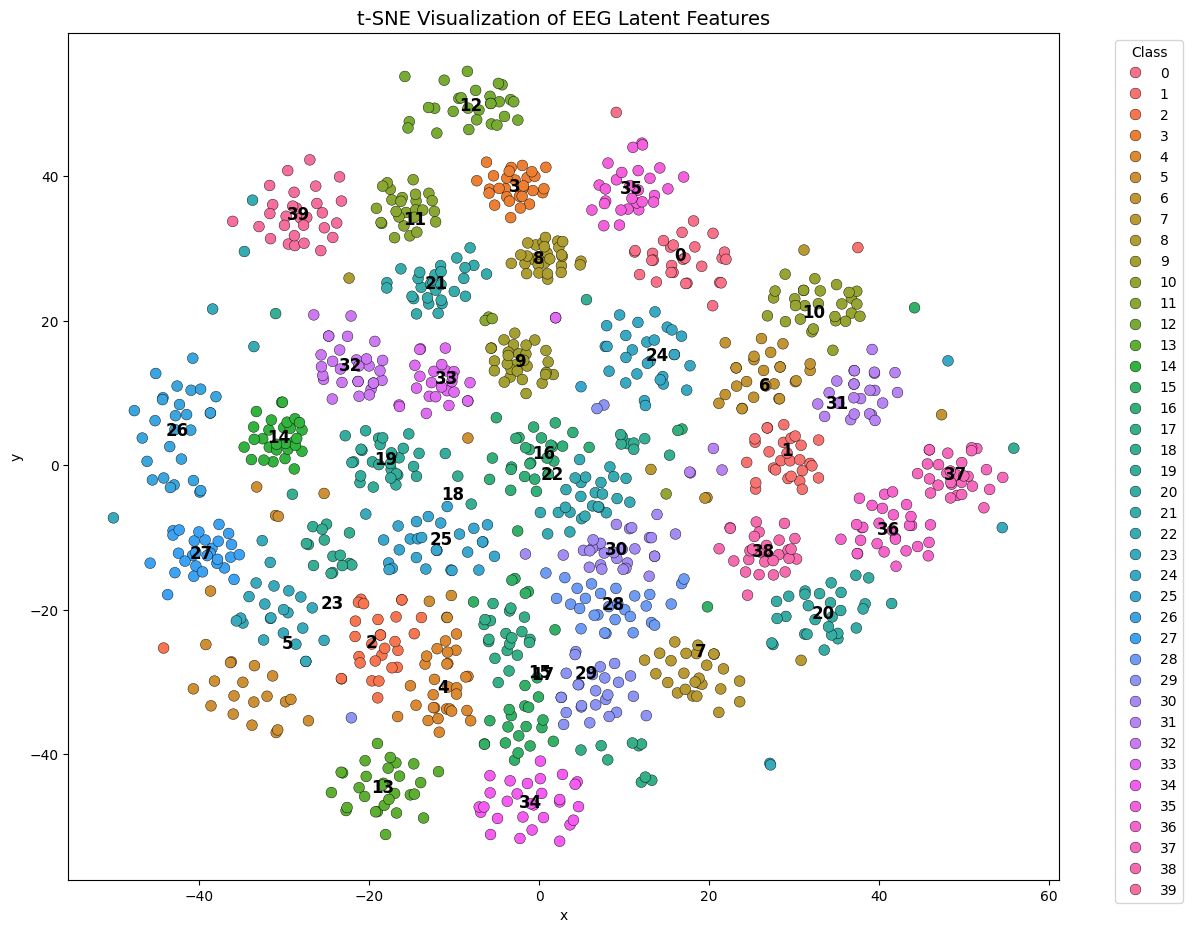

In [8]:
import seaborn as sns
import pandas as pd

colors = sns.color_palette("husl", 40)  # 💡 가장 시각적으로 잘 구분됨

eeg_tsne = tsne.fit_transform(eeg_embeddings)
eeg_tsne = cp.asnumpy(eeg_tsne)

df = pd.DataFrame({
    "x": eeg_tsne[:, 0],
    "y": eeg_tsne[:, 1],
    "label": eeg_labels[:,0]
})

plt.figure(figsize=(12, 10))
palette = sns.color_palette("husl", np.unique(eeg_labels).shape[0])
sns.scatterplot(data=df, x="x", y="y", hue="label", palette=palette, s=60, edgecolor='black', linewidth=0.3)
for label, group in df.groupby('label'):
    x_mean = group['x'].mean()
    y_mean = group['y'].mean()
    plt.text(x_mean, y_mean, str(label), fontsize=12, weight='bold', ha='center', va='center')


plt.title("t-SNE Visualization of EEG Latent Features", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Class")
plt.tight_layout()
plt.show()

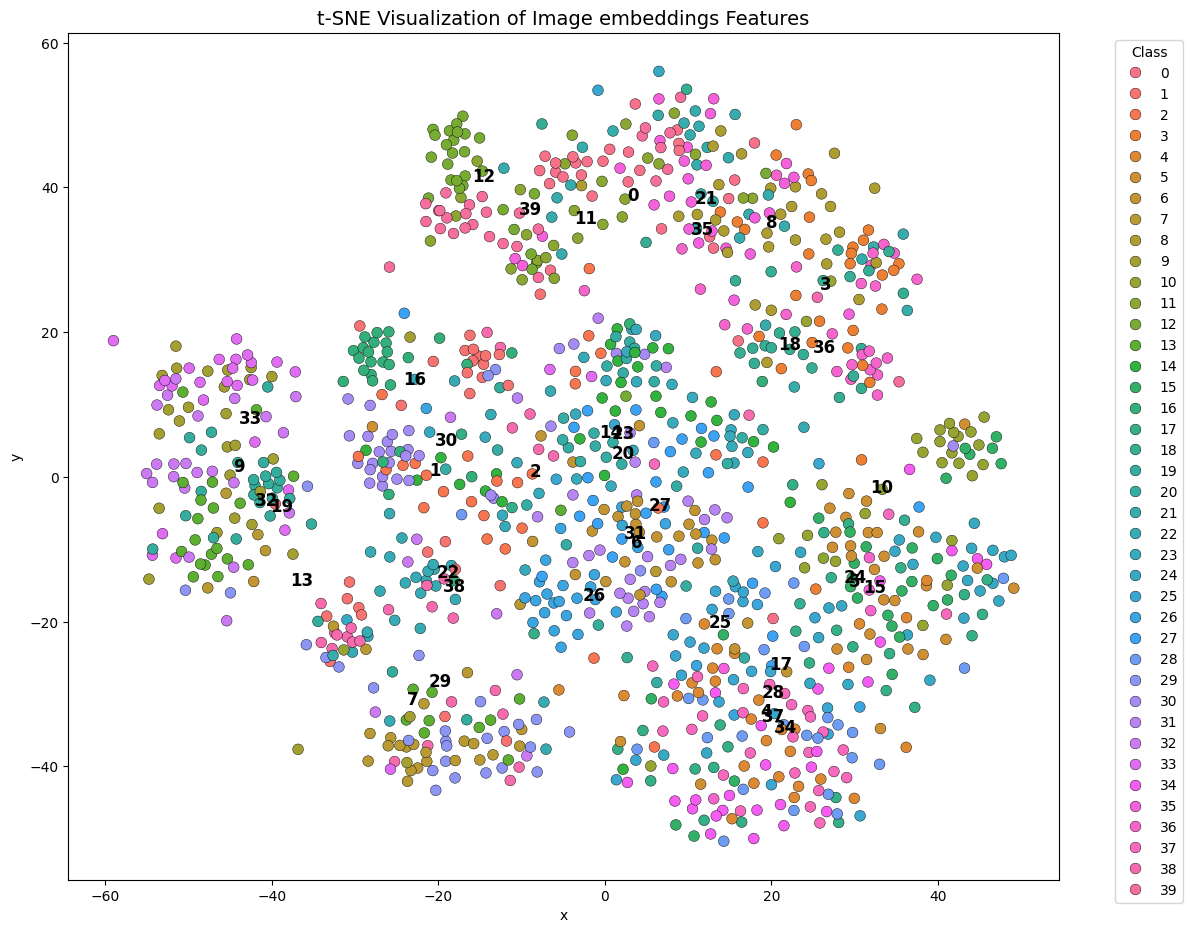

In [9]:
colors = sns.color_palette("husl", 40)  # 💡 가장 시각적으로 잘 구분됨

image_tsne = tsne.fit_transform(image_embeddings)
image_tsne = cp.asnumpy(image_tsne)

df = pd.DataFrame({
    "x": image_tsne[:, 0],
    "y": image_tsne[:, 1],
    "label": eeg_labels[:,0]
})

plt.figure(figsize=(12, 10))
palette = sns.color_palette("husl", np.unique(eeg_labels).shape[0])
sns.scatterplot(data=df, x="x", y="y", hue="label", palette=palette, s=60, edgecolor='black', linewidth=0.3)
for label, group in df.groupby('label'):
    x_mean = group['x'].mean()
    y_mean = group['y'].mean()
    plt.text(x_mean, y_mean, str(label), fontsize=12, weight='bold', ha='center', va='center')


plt.title("t-SNE Visualization of Image embeddings Features", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Class")
plt.tight_layout()
plt.show()

## Test Dataset Test

In [4]:
topk_retrival(mode="test")

test Embeddings:   0%|          | 0/153 [00:00<?, ?it/s]

Local Metric Result
top1_img_acc : 0.5318627450980392 top1_label_acc : 0.5841503267973857 top3_img_acc : 0.798202614379085 top3_label_acc : 0.8169934640522876 top5_img_acc : 0.8954248366013072 top5_label_acc : 0.9027777777777778 top1_name_acc : 0.0 top3_name_acc : 0.0 top5_name_acc : 0.0 
Global Metric Result
top1_img_acc : 0.011437908496732025 top1_label_acc : 0.5866013169288635 top3_img_acc : 0.04003267973856209 top3_label_acc : 0.8799019455909729 top5_img_acc : 0.07516339869281045 top5_label_acc : 0.968137264251709 top1_name_acc : 1.0 top3_name_acc : 1.0 top5_name_acc : 1.0 


In [5]:
image_embeddings = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.image_embed_lst))
eeg_embeddings   = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.eeg_latent_lst))
eeg_labels       = topk_retrival.label.detach().cpu().numpy()

/tmp/ipykernel_174056/1831532104.py:1: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  image_embeddings = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.image_embed_lst))
/tmp/ipykernel_174056/1831532104.py:2: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  eeg_embeddings   = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.eeg_latent_lst))


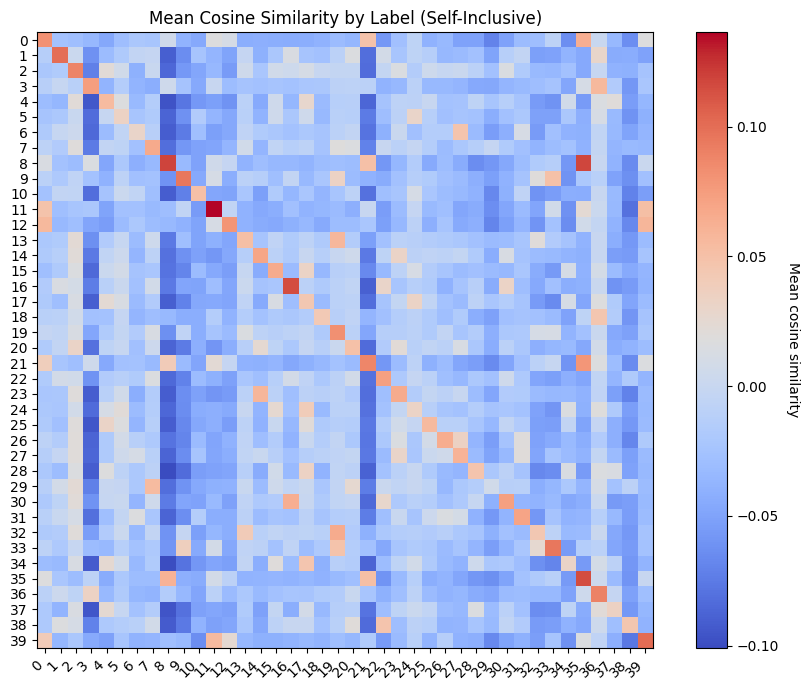

In [28]:
import numpy as np
import matplotlib.pyplot as plt



cos_sim = image_embeddings@eeg_embeddings.T
labels = eeg_labels.ravel()
unique_labels = np.unique(labels)
L = len(unique_labels)

label_to_idx = {lbl: np.where(labels == lbl)[0] for lbl in unique_labels}
heat = np.zeros((L, L), dtype=float)
for i, li in enumerate(unique_labels):
    idx_i = label_to_idx[li]
    for j, lj in enumerate(unique_labels):
        idx_j = label_to_idx[lj]
        block = cos_sim[np.ix_(idx_i, idx_j)]
        heat[i, j] = block.mean()

# --------- ??? ----------
fig, ax = plt.subplots(figsize=(9, 7))   # ? ? ???
im = ax.imshow(heat, aspect='equal', cmap='coolwarm', interpolation='nearest')  # ?? ??

ax.set_xticks(range(L))
ax.set_yticks(range(L))
ax.set_xticklabels(unique_labels, rotation=45, ha='right')
ax.set_yticklabels(unique_labels)

ax.set_title('Mean Cosine Similarity by Label (Self-Inclusive)')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Mean cosine similarity', rotation=270, labelpad=15)

# ? ? ??(??? True)
annotate = False
if annotate:
    for i in range(L):
        for j in range(L):
            ax.text(j, i, f"{heat[i,j]:.2f}", ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()


# For select class

In [40]:
labels[803]

3

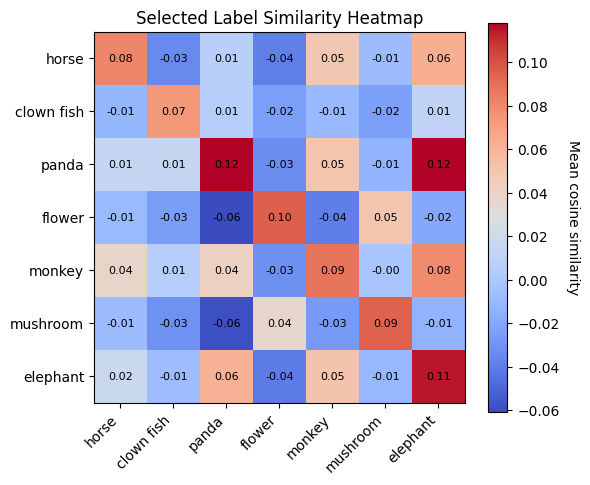

In [51]:
label_lst= {
    0:'horse',
    3:'clown fish',
    8:'panda',
    9:'flower',
    21:'monkey',
    33:'mushroom',
    35:'elephant'    
}
# selected_labels = [0, 3, 8, 9, 21, 33, 35]  
selected_labels = list(label_lst.keys())  
selected_names  = list(label_lst.values())


selected_labels = [lbl for lbl in selected_labels if lbl in unique_labels]
indices = [np.where(unique_labels == lbl)[0][0] for lbl in selected_labels]
sub_heat = heat[np.ix_(indices, indices)]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(sub_heat, aspect='equal', cmap='coolwarm', interpolation='nearest')

ax.set_xticks(range(len(selected_names)))
ax.set_yticks(range(len(selected_names)))
ax.set_xticklabels(selected_names, rotation=45, ha='right')
ax.set_yticklabels(selected_names)

ax.set_title(f'Selected Label Similarity Heatmap')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Mean cosine similarity', rotation=270, labelpad=15)


for i in range(len(selected_labels)):
    for j in range(len(selected_labels)):
        ax.text(j, i, f"{sub_heat[i, j]:.2f}", ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

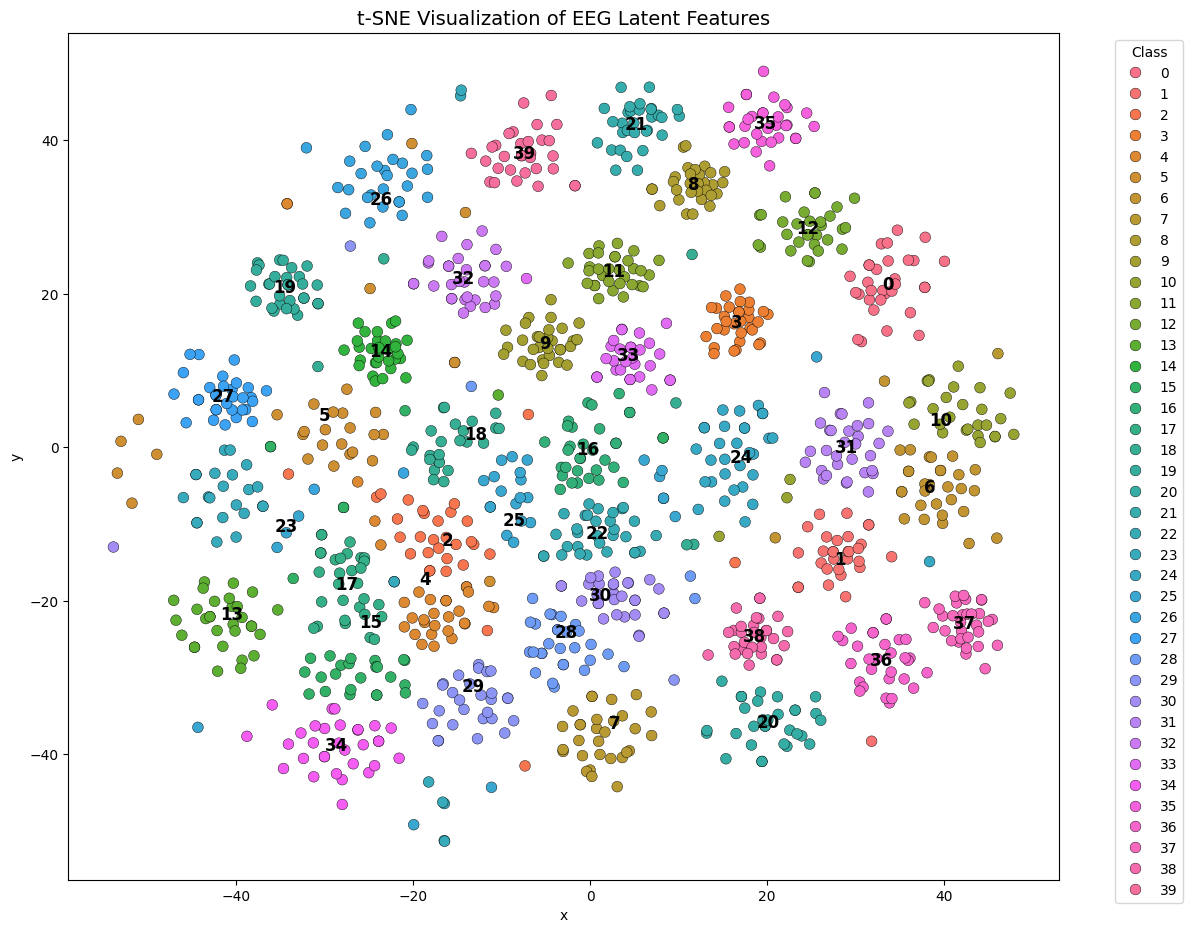

In [12]:
import seaborn as sns
import pandas as pd

colors = sns.color_palette("husl", 40)  # 💡 가장 시각적으로 잘 구분됨

eeg_tsne = tsne.fit_transform(eeg_embeddings)
eeg_tsne = cp.asnumpy(eeg_tsne)

df = pd.DataFrame({
    "x": eeg_tsne[:, 0],
    "y": eeg_tsne[:, 1],
    "label": eeg_labels[:,0]
})

plt.figure(figsize=(12, 10))
palette = sns.color_palette("husl", np.unique(eeg_labels).shape[0])
sns.scatterplot(data=df, x="x", y="y", hue="label", palette=palette, s=60, edgecolor='black', linewidth=0.3)
for label, group in df.groupby('label'):
    x_mean = group['x'].mean()
    y_mean = group['y'].mean()
    plt.text(x_mean, y_mean, str(label), fontsize=12, weight='bold', ha='center', va='center')


plt.title("t-SNE Visualization of EEG Latent Features", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Class")
plt.tight_layout()
plt.show()

# Subject 4

In [3]:
config_path   = os.path.join(".","config","EEGLDM2_sub4_Train.json")
topk_retrival = Test_TopK_Retrival(json_path=config_path)

Start Load...
End Time : 0.0220s
Start Load...
End Time : 0.0026s
missing keys: []
unexpectesc keys: []


## Validation Test
---
Local Batch 11

In [4]:
topk_retrival()

valid Embeddings:   0%|          | 0/26 [00:00<?, ?it/s]

Local Metric Result
top1_img_acc : 0.3525641025641024 top1_label_acc : 0.4329836947413591 top3_img_acc : 0.6095571095571095 top3_label_acc : 0.6515151686393298 top5_img_acc : 0.776223776223776 top5_label_acc : 0.8111888399490943 top1_name_acc : 0.0 top3_name_acc : 0.0 top5_name_acc : 0.0 
Global Metric Result
top1_img_acc : 0.03914590747330961 top1_label_acc : 0.38790035247802734 top3_img_acc : 0.1423487544483986 top3_label_acc : 0.6441280841827393 top5_img_acc : 0.20640569395017794 top5_label_acc : 0.8149465918540955 top1_name_acc : 0.03914590747330961 top3_name_acc : 0.1423487544483986 top5_name_acc : 0.20640569395017794 


In [41]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)

In [42]:
image_embeddings = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.image_embed_lst))
eeg_embeddings   = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.eeg_latent_lst))
eeg_labels       = topk_retrival.label.detach().cpu().numpy()

/tmp/ipykernel_2969033/1831532104.py:1: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  image_embeddings = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.image_embed_lst))
/tmp/ipykernel_2969033/1831532104.py:2: DeprecationWarning: This function is deprecated in favor of cupy.from_dlpack
  eeg_embeddings   = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.eeg_latent_lst))


In [43]:
np.unique(eeg_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

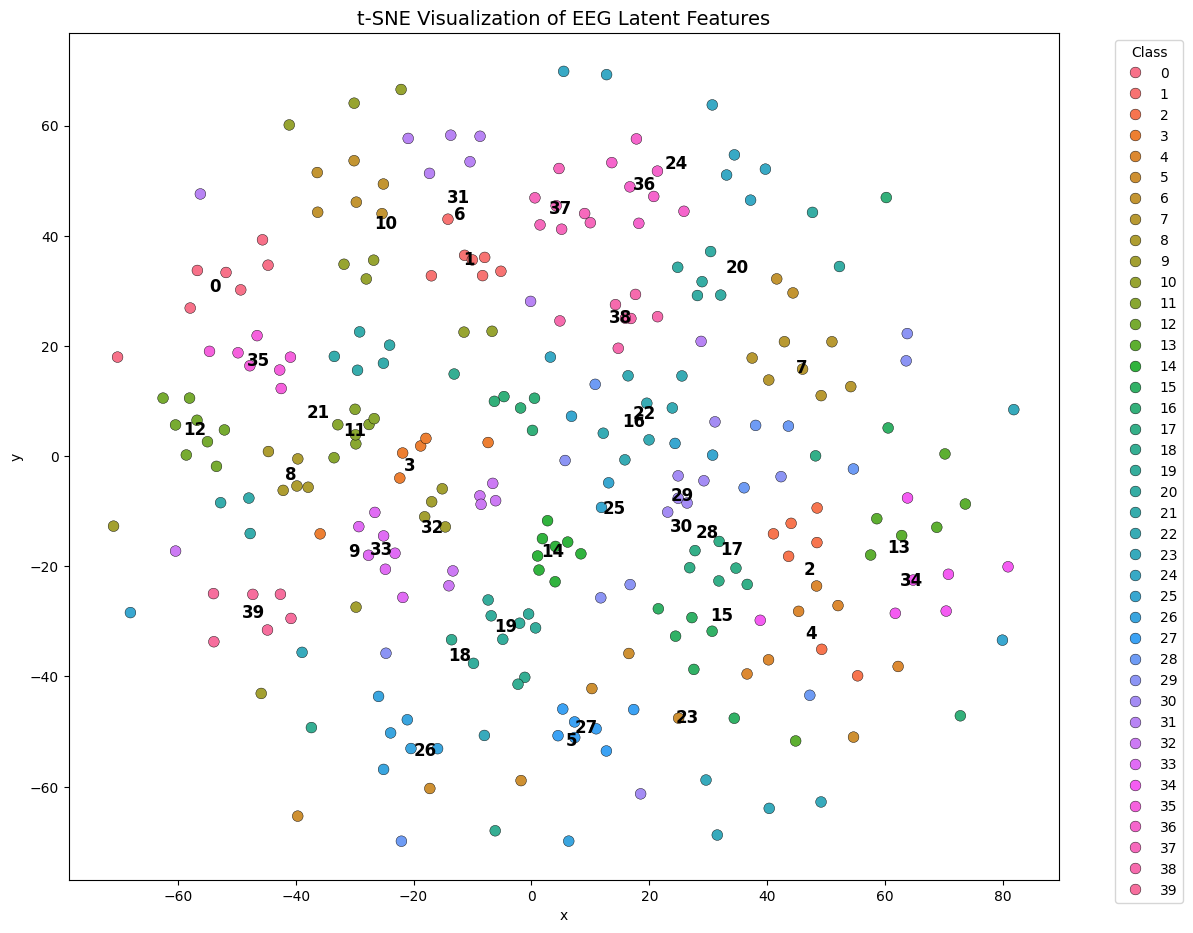

In [44]:
import seaborn as sns
import pandas as pd

colors = sns.color_palette("husl", 40)  # 💡 가장 시각적으로 잘 구분됨

eeg_tsne = tsne.fit_transform(eeg_embeddings)
eeg_tsne = cp.asnumpy(eeg_tsne)

df = pd.DataFrame({
    "x": eeg_tsne[:, 0],
    "y": eeg_tsne[:, 1],
    "label": eeg_labels[:,0]
})

plt.figure(figsize=(12, 10))
palette = sns.color_palette("husl", np.unique(eeg_labels).shape[0])
sns.scatterplot(data=df, x="x", y="y", hue="label", palette=palette, s=60, edgecolor='black', linewidth=0.3)
for label, group in df.groupby('label'):
    x_mean = group['x'].mean()
    y_mean = group['y'].mean()
    plt.text(x_mean, y_mean, str(label), fontsize=12, weight='bold', ha='center', va='center')


plt.title("t-SNE Visualization of EEG Latent Features", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Class")
plt.tight_layout()
plt.show()

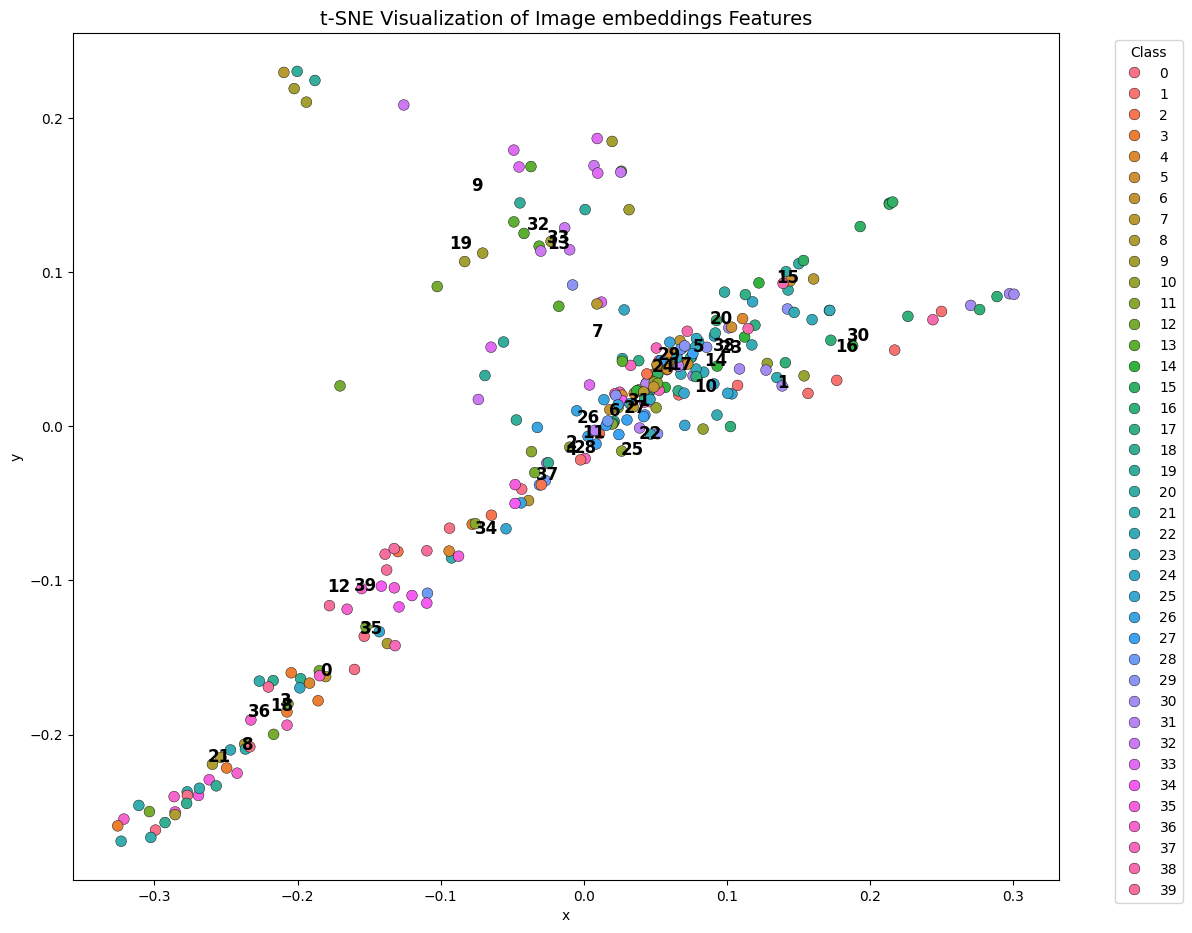

In [45]:
colors = sns.color_palette("husl", 40)  # 💡 가장 시각적으로 잘 구분됨

image_tsne = tsne.fit_transform(image_embeddings)
image_tsne = cp.asnumpy(image_tsne)

df = pd.DataFrame({
    "x": image_tsne[:, 0],
    "y": image_tsne[:, 1],
    "label": eeg_labels[:,0]
})

plt.figure(figsize=(12, 10))
palette = sns.color_palette("husl", np.unique(eeg_labels).shape[0])
sns.scatterplot(data=df, x="x", y="y", hue="label", palette=palette, s=60, edgecolor='black', linewidth=0.3)
for label, group in df.groupby('label'):
    x_mean = group['x'].mean()
    y_mean = group['y'].mean()
    plt.text(x_mean, y_mean, str(label), fontsize=12, weight='bold', ha='center', va='center')


plt.title("t-SNE Visualization of Image embeddings Features", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Class")
plt.tight_layout()
plt.show()

In [ ]:
topk_retrival(mode="test")

In [ ]:
image_embeddings = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.image_embed_lst))
eeg_embeddings   = cp.fromDlpack(dlpack.to_dlpack(topk_retrival.eeg_latent_lst))
eeg_labels       = topk_retrival.label.detach().cpu().numpy()

In [ ]:
import seaborn as sns
import pandas as pd

colors = sns.color_palette("husl", 40)  # 💡 가장 시각적으로 잘 구분됨

eeg_tsne = tsne.fit_transform(eeg_embeddings)
eeg_tsne = cp.asnumpy(eeg_tsne)

df = pd.DataFrame({
    "x": eeg_tsne[:, 0],
    "y": eeg_tsne[:, 1],
    "label": eeg_labels[:,0]
})

plt.figure(figsize=(12, 10))
palette = sns.color_palette("husl", np.unique(eeg_labels).shape[0])
sns.scatterplot(data=df, x="x", y="y", hue="label", palette=palette, s=60, edgecolor='black', linewidth=0.3)
for label, group in df.groupby('label'):
    x_mean = group['x'].mean()
    y_mean = group['y'].mean()
    plt.text(x_mean, y_mean, str(label), fontsize=12, weight='bold', ha='center', va='center')


plt.title("t-SNE Visualization of EEG Latent Features", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Class")
plt.tight_layout()
plt.show()